# Multi-digit Number Recognition from Street View Imagery using Deep Convolutional Neural Networks

The goal of this project was to create end-to-end Deep Convolutional Neural Networks applied on the Street View House Numbers dataset to classify multi-digit numbers. Tensorflow was used to achieve this task.

The VHNS dataset is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST dataset, but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem : recognizing digits and numbers in natural scene images. SVHN is obtained from house numbers in Google Street View images.

To solve this issue, I replicated the work of Ian J.Goodfellow in his paper Multi-digit Number Recognition from Street View Imagery using Deep Convolutional Neural Networks aimed at classifying VHNS images.

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import os
from six.moves.urllib.request import urlretrieve
import tarfile
import sys
import scipy.io as sio
import h5py
from DigitStructFile import *
%matplotlib inline

## 1. Data Loading

We first need to download the data as zip files:

In [ ]:
url = 'http://ufldl.stanford.edu/housenumbers/'

def download_afile(filename):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    return filename

train_filename = download_afile('train.tar.gz')
test_filename = download_afile('test.tar.gz')

Then extract the content of the zip files:

In [ ]:
def extract_afile(filename):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root):
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = root
    print(data_folders)
    return data_folders
  
train_folders = extract_afile(train_filename)
test_folders = extract_afile(test_filename)

Finally we extract images from the .mat files using helper functions to be found in DigitStructFile.py script, and store images in train and test folders:

In [ ]:
train_folders = 'train'
test_folders = 'test'

fin = os.path.join(train_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
train_data = dsf.getAllDigitStructure_ByDigit()

print('Train ready')

fin = os.path.join(test_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
test_data = dsf.getAllDigitStructure_ByDigit()

print('Test ready')

Finally we store the metadata in pickle files:

In [ ]:
pickle_file = 'temp_train.pickle'

try:
    with open(pickle_file, 'wb') as f:
        pickle.dump(train_data, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
pickle_file = 'temp_test.pickle'

try:
    f = open(pickle_file, 'wb')
    pickle.dump(test_data, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Now that we've downloaded the data and stored it into pickle files, we can load it and preprocess it:

In [16]:
train_folders = 'train'
test_folders = 'test'

pickle_name = 'temp_train.pickle'

with open(pickle_name, 'rb') as f:
    train_data = pickle.load(f)
    
pickle_name = 'temp_test.pickle'

with open(pickle_name, 'rb') as f:
    test_data = pickle.load(f)

In [3]:
train_data[0]

{'boxes': [{'height': 219.0,
   'label': 1.0,
   'left': 246.0,
   'top': 77.0,
   'width': 81.0},
  {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}],
 'filename': '1.png'}

In [4]:
print('Number of images in train dataset: ',len(train_data))
print('Number of images in test dataset: ',len(test_data))

Number of images in train dataset:  33402
Number of images in test dataset:  13068


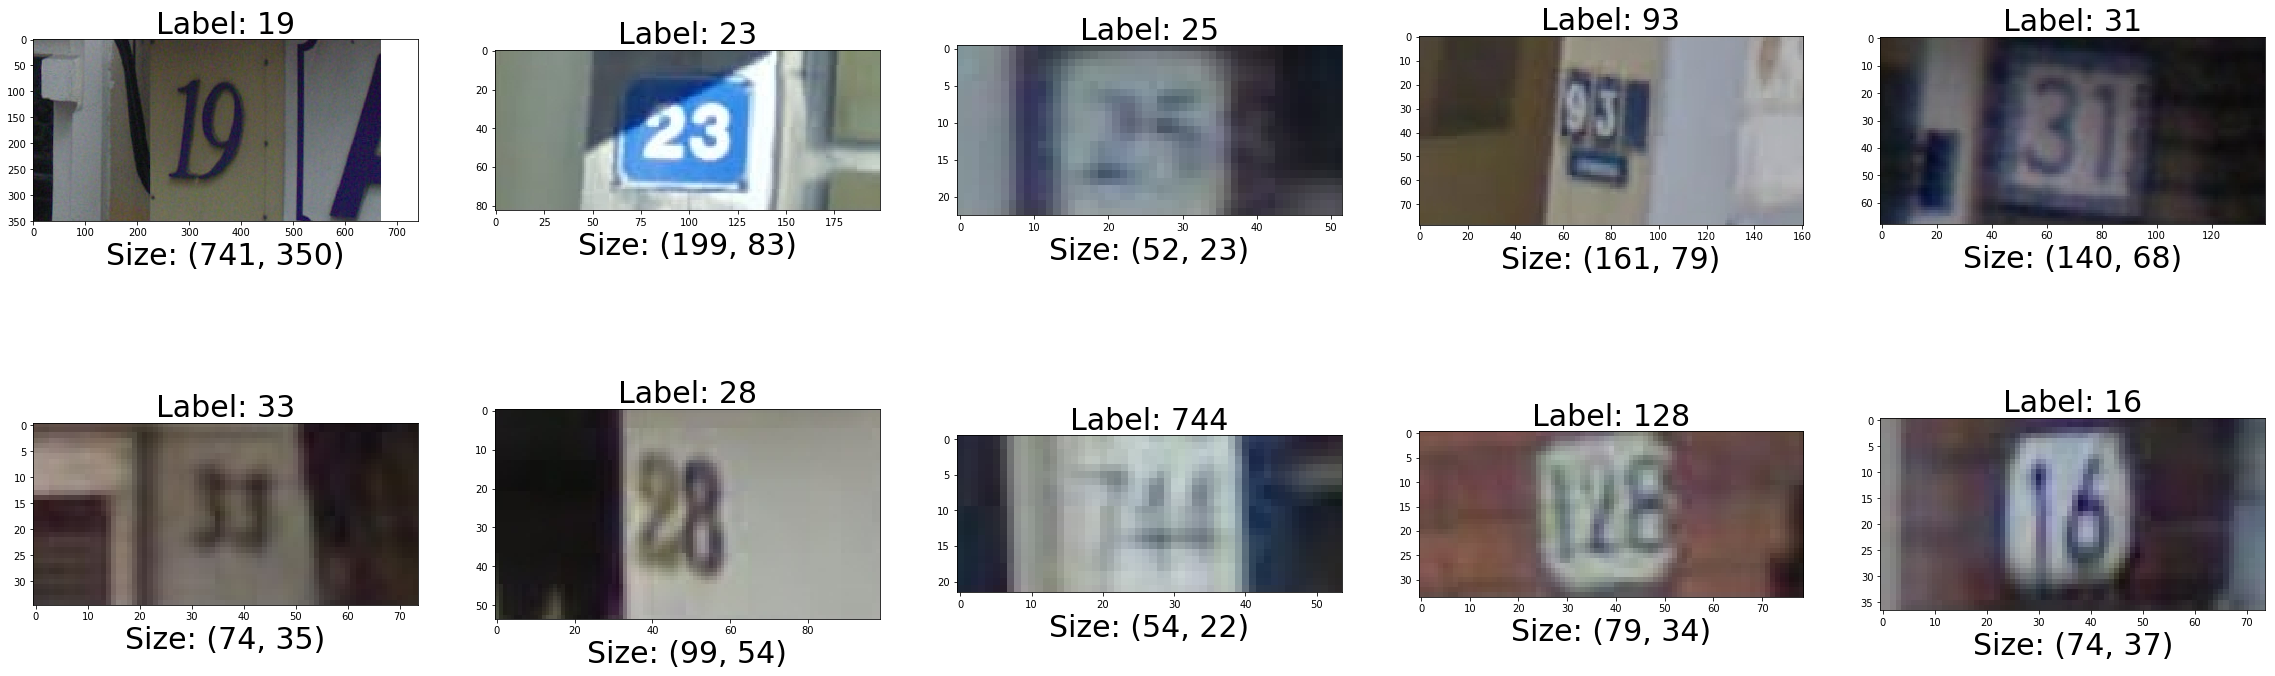

In [4]:
# Show sample images

from PIL import Image

images = [Image.open(os.path.join('train',train_data[j]['filename'])) for j in range(10)]

labels = ['']*10
for j in range(10):
    for i in range(len(train_data[j]['boxes'])):
        labels[j] += str(int(train_data[j]['boxes'][i]['label']))

plt.figure(figsize=(40,20))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title('Label: '+labels[i], fontsize=30)
    plt.xlabel('Size: '+str(image.size), fontsize=30)
    plt.imshow(image)

In [5]:
#Images with different sizes

def biggest_image(folder, data):
    max_size = 0
    max_index = -1
    for i in range(len(data)):
        im_size = Image.open(os.path.join(folder,data[i]['filename'])).size
        size = im_size[0]*im_size[1]
        if size > max_size:
            max_size = size
            max_index = i
    max_size = Image.open(os.path.join(folder,data[max_index]['filename'])).size
    return max_size, max_index

def smallest_image(folder, data):
    min_size = 1000000
    min_index = -1
    for i in range(len(data)):
        im_size = Image.open(os.path.join(folder,data[i]['filename'])).size
        size = im_size[0]*im_size[1]
        if size < min_size:
            min_size = size
            min_index = i
    min_size = Image.open(os.path.join(folder,data[min_index]['filename'])).size
    return min_size, min_index

max_train_size, max_train_index = biggest_image('train', train_data)
min_train_size, min_train_index = smallest_image('train', train_data)

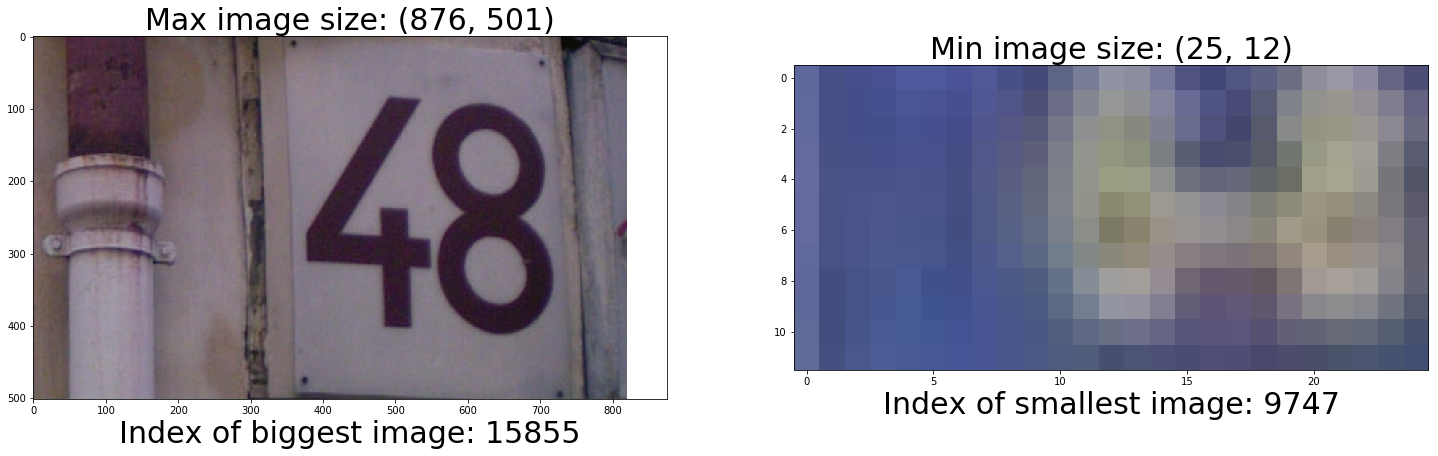

In [6]:
plt.figure(figsize=(25,15))
plt.subplot(121)
plt.title("Max image size: "+str(max_train_size), fontsize=30)
plt.xlabel("Index of biggest image: "+str(max_train_index), fontsize=30)
plt.imshow(Image.open(os.path.join('train',train_data[max_train_index]['filename'])))

plt.subplot(122)
plt.title("Min image size: "+str(min_train_size), fontsize=30)
plt.xlabel("Index of smallest image: "+str(min_train_index), fontsize=30)
plt.imshow(Image.open(os.path.join('train',train_data[min_train_index]['filename'])))

In [7]:
def get_num_lengths(data):
    num_lengths = [0]*6
    for i in range(len(data)):
        index = len(data[i]['boxes'])
        if index > 5:
            num_lengths[-1] += 1
        else:
            num_lengths[index-1] += 1
    return num_lengths
        
train_num_lengths = get_num_lengths(train_data)
test_num_lengths = get_num_lengths(test_data)

([<matplotlib.axis.XTick at 0x122b06390>,
 <a list of 6 Text xticklabel objects>)

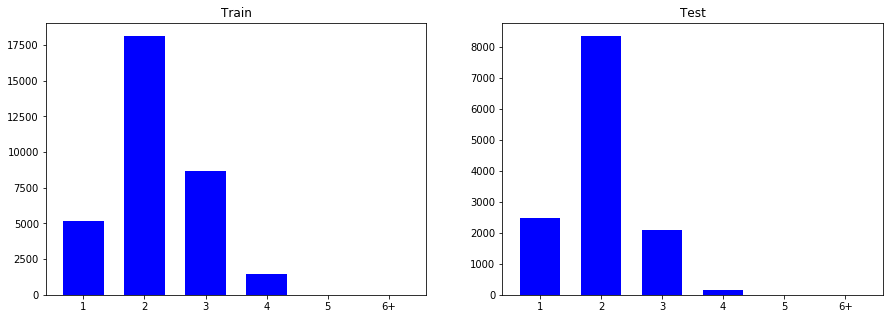

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(121)
y = train_num_lengths
N = len(y)
x = range(N)
width = 1/1.5
plt.title('Train')
plt.bar(x, y, width, color="blue")
labels = ['1','2','3','4','5','6+']
plt.xticks(x,labels)


plt.subplot(122)
y = test_num_lengths
N = len(y)
x = range(N)
width = 1/1.5
plt.title('Test')
plt.bar(x, y, width, color="blue")
plt.xticks(x,labels)

Let's have a look at the different labels :

In [9]:
labels = []

for i in range(len(train_data)):
    for j in range(len(train_data[i]['boxes'])):
        if train_data[i]['boxes'][j]['label'] not in labels:
            labels.append(train_data[i]['boxes'][j]['label'])
print("Labels of single numbers are: ",labels)

Labels of single numbers are:  [1.0, 9.0, 2.0, 3.0, 5.0, 8.0, 7.0, 4.0, 6.0, 10.0]


We see that labels range from 1 to 10 so it seems that the number 0 has label 10. Let's verify this assumption, printing a number with a zero, and its corresponding labels.

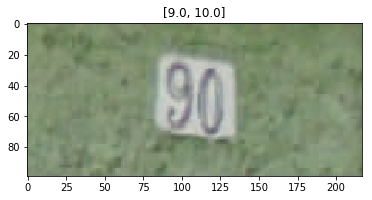

In [10]:
index = 32999

im = Image.open(os.path.join('train',train_data[32999]['filename']))
labels = [train_data[index]['boxes'][0]['label'], train_data[index]['boxes'][1]['label']]
plt.title(labels)
plt.imshow(im)

Now Let's print the bounding box around numbers. In fact, the dataset provides bounding boxes for each number so we need to merge these multiple bounding boxes into one that surronds the whole number.

Then, before croping each image in the dataset around its bounding boxes, let's increase the size of the bounding box by 30%. This preprocessing step was also done by J.Goodfellow in the paper we mentionned before.

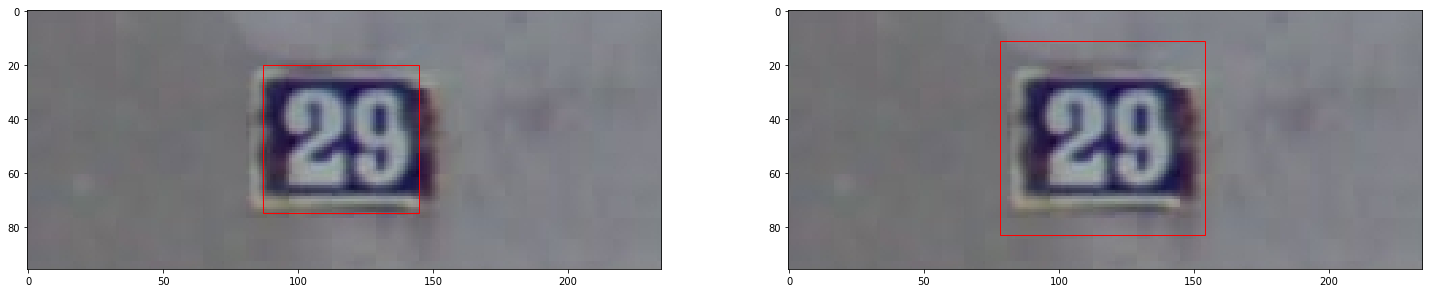

In [12]:
#Bounding boxes
import matplotlib.patches as patches

def get_bounding_box(meta_dict):
    num_digit = len(meta_dict['boxes'])
    boxes = meta_dict['boxes']
    
    # Get the individual bounding boxes
    top = np.ndarray([num_digit], dtype='float32')
    left = np.ndarray([num_digit], dtype='float32')
    height = np.ndarray([num_digit], dtype='float32')
    width = np.ndarray([num_digit], dtype='float32')
        
    for j in np.arange(num_digit):
        top[j] = boxes[j]['top']
        left[j] = boxes[j]['left']
        height[j] = boxes[j]['height']
        width[j] = boxes[j]['width']
        
    # Get the bounding box surrounding all digits
    im_top = np.amin(top)
    im_left = np.amin(left)
    im_height = np.amax(top) + height[np.argmax(top)] - im_top
    im_width = np.amax(left) + width[np.argmax(left)] - im_left
    
    return im_top, im_left, im_height, im_width

def increase_bounding_box(meta_dict, im_size, increase_factor):
    im_top, im_left, im_height, im_width = get_bounding_box(meta_dict)
    new_height = np.amin([np.ceil((1+increase_factor)*im_height), im_size[1]])
    new_width = np.amin([np.ceil((1+increase_factor)*im_width), im_size[0]])
    new_left = np.amax([np.floor(im_left - increase_factor*im_width/2),0])
    new_top = np.amax([np.floor(im_top - increase_factor*im_height/2),0])
    return new_top, new_left, new_height, new_width
    
#Index of the image to show
im_index = 42

#Open the image
im = Image.open(os.path.join('train',train_data[im_index]['filename']))

#Find the bounding box of the image + extended bounding box
im_top, im_left, im_height, im_width = get_bounding_box(train_data[im_index])
new_top, new_left, new_height, new_width = increase_bounding_box(train_data[im_index],im.size,0.3)

#Create a figure
fig = plt.figure(figsize=(25,15))

# Create subplots
ax1 = fig.add_subplot(121)
ax1.imshow(im)
rect = patches.Rectangle((im_left,im_top),im_width,im_height,linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect)

ax2 = fig.add_subplot(122)
ax2.imshow(im)
rect = patches.Rectangle((new_left,new_top),new_width,new_height,linewidth=1,edgecolor='r',facecolor='none')
ax2.add_patch(rect)

#Show the figure
plt.show()

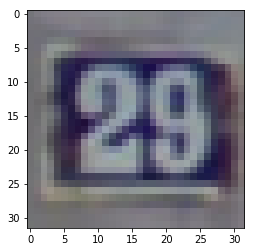

In [14]:
#Croping and resizing 32x32
IM_SIZE = 32

im_test = im.crop((int(new_left), int(new_top), int(new_left + new_width), int(new_top + new_height))).resize([IM_SIZE,IM_SIZE], Image.ANTIALIAS)

plt.imshow(im_test)

In [17]:
from PIL import Image

IM_SIZE = 32

def generate_dataset(data, folder):
    dataset = np.ndarray([int(len(data)*0.8),IM_SIZE,IM_SIZE], dtype='float32')
    labels = np.ndarray([int(len(data)*0.8),5], dtype='int32')
    length = np.ndarray([int(len(data)*0.8)], dtype='int32')

    for i in np.arange(int(len(data)*0.8)):
        filename = data[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        num_digit = len(data[i]['boxes'])
        boxes = data[i]['boxes']
        
        if num_digit > 5: 
            continue

        # Get the expanded bounding box by 30%
        im_top, im_left, im_height, im_width = increase_bounding_box(data[i],im.size,0.3)
        
        # Cropping the expanded bounding box
        im = im.crop((int(im_left), int(im_top), int(im_left + im_width), int(im_top + im_height))).resize([IM_SIZE,IM_SIZE], Image.ANTIALIAS)
        #Transform into grayscale
        im = (np.array(im)[:,:,0]*0.299 + np.array(im)[:,:,1]*0.587 + np.array(im)[:,:,2]*0.114)/3
        dataset[i,:,:] = im
        
        for digit in range(num_digit):
            temp_label = data[i]['boxes'][digit]['label']
            labels[i,digit] = temp_label
        for digit in range(5-num_digit):
            labels[i,4-digit] = 0
        length[i] = int(num_digit-1)
        
    dataset = dataset.reshape((-1, IM_SIZE, IM_SIZE, 1)).astype(np.float32)

    return dataset, labels, length


train_dataset, train_labels, train_length = generate_dataset(train_data, train_folders)
print(train_dataset.shape, train_labels.shape, train_length.shape)
del train_data

test_dataset, test_labels, test_length = generate_dataset(test_data, test_folders)
print(test_dataset.shape, test_labels.shape, test_length.shape)
del test_data

(26721, 32, 32, 1) (26721, 5) (26721,)
(10454, 32, 32, 1) (10454, 5) (10454,)


Label 1 : 1
Label 2 : 9
Label 3 : 0
Label 4 : 0
Label 5 : 0
Length: 2


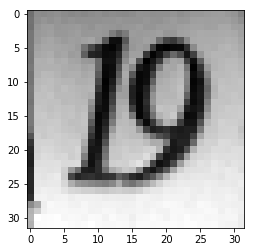

In [19]:
im_number = 0
plt.imshow(train_dataset[im_number,:,:,:].reshape((IM_SIZE,IM_SIZE)), cmap='gray')
for i in range(5):
    print("Label",i+1,":",train_labels[im_number,i])

print("Length:",train_length[im_number]+1)

## 2.2 Data Training

We subtract the mean from images as a preprocessing step:

In [8]:
def subtract_mean(a):
    a = (a - np.mean(a, axis=0)) / np.std(a, axis=0)
    return a


# Subtract the mean from every image
train_dataset = subtract_mean(train_dataset)
test_dataset = subtract_mean(test_dataset)

In [9]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, axis=1) == labels)
          / len(predictions))

Then we construct the following architecture:

$INPUT -> [[CONV -> RELU]*2 -> POOL]*2 -> [[CONV -> RELU]*3 -> POOL] -> [FC -> RELU]*2 -> OUTPUT$

In [20]:
batch_size = 128
patch_size = 5
depth = 32
num_hidden = 256
image_size = IM_SIZE
num_channels = 1

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels), name='train_data')
    tf_train_lengths = tf.placeholder(tf.int32, shape=(batch_size), name='train_lengths')
    tf_train_labels1 = tf.placeholder(tf.int32, shape=(batch_size), name='train_labels1')
    tf_train_labels2 = tf.placeholder(tf.int32, shape=(batch_size), name='train_labels2')
    tf_train_labels3 = tf.placeholder(tf.int32, shape=(batch_size), name='train_labels3')
    tf_train_labels4 = tf.placeholder(tf.int32, shape=(batch_size), name='train_labels4')
    tf_train_labels5 = tf.placeholder(tf.int32, shape=(batch_size), name='train_labels5')
    tf_test_dataset = tf.constant(test_dataset, name='test_data')
  
    # Variables.
    layer1_weights = tf.get_variable('layer1',
      [patch_size, patch_size, num_channels, depth], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.get_variable('layer2',
      [patch_size, patch_size, depth, depth], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.get_variable('layer3',
      [patch_size, patch_size, depth, depth*2], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[depth*2]))
    layer4_weights = tf.get_variable('layer4',
      [patch_size, patch_size, depth*2, depth*2], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[depth*2]))
    layer5_weights = tf.get_variable('layer5',
      [patch_size, patch_size, depth*2, depth*2*2], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[depth*2*2]))
    layer6_weights = tf.get_variable('layer6',
      [patch_size, patch_size, depth*2*2, depth*4], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer6_biases = tf.Variable(tf.constant(1.0, shape=[depth*4]))
    layer7_weights = tf.get_variable('layer7',
      [patch_size, patch_size, depth*4, depth*4], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer7_biases = tf.Variable(tf.constant(1.0, shape=[depth*4]))
    layer8_weights = tf.get_variable('layer8',
      [2048, num_hidden], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer8_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer9_weights = tf.get_variable('layer9',
      [num_hidden, num_hidden], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer9_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer10_weights = tf.get_variable('layer10',
      [num_hidden, 5], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer10_biases = tf.Variable(tf.constant(1.0, shape=[5]))
    layer11_weights = tf.get_variable('layer11',
      [num_hidden, 11], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer11_biases = tf.Variable(tf.constant(1.0, shape=[11]))
    layer12_weights = tf.get_variable('layer12',
      [num_hidden, 11], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer12_biases = tf.Variable(tf.constant(1.0, shape=[11]))
    layer13_weights = tf.get_variable('layer13',
      [num_hidden, 11], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer13_biases = tf.Variable(tf.constant(1.0, shape=[11]))
    layer14_weights = tf.get_variable('layer14',
      [num_hidden, 11], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer14_biases = tf.Variable(tf.constant(1.0, shape=[11]))
    layer15_weights = tf.get_variable('layer15',
      [num_hidden, 11], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer15_biases = tf.Variable(tf.constant(1.0, shape=[11]))
  
    # Model.
    def model(data, layer_weights, layer_biases):
        
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
        
        conv = tf.nn.conv2d(pool, layer3_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer3_biases)
        
        conv = tf.nn.conv2d(hidden, layer4_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer4_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
        
        conv = tf.nn.conv2d(pool, layer5_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer5_biases)
        
        conv = tf.nn.conv2d(hidden, layer6_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer6_biases)
        
        conv = tf.nn.conv2d(hidden, layer7_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer7_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
                
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer8_weights) + layer8_biases)
        hidden = tf.nn.relu(tf.matmul(hidden, layer9_weights) + layer9_biases)
        
        return tf.matmul(hidden, layer_weights) + layer_biases

    # Training computation.
    logits1 = model(tf_train_dataset, layer10_weights, layer10_biases)
    loss1 = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_lengths, logits=logits1))
    
    logits2 = model(tf_train_dataset, layer11_weights, layer11_biases)
    loss2 = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels1, logits=logits2))
    
    logits3 = model(tf_train_dataset, layer12_weights, layer12_biases)
    loss3 = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels2, logits=logits3))
    
    logits4 = model(tf_train_dataset, layer13_weights, layer13_biases)
    loss4 = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels3, logits=logits4))
    
    logits5 = model(tf_train_dataset, layer14_weights, layer14_biases)
    loss5 = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels4, logits=logits5))
    
    logits6 = model(tf_train_dataset, layer15_weights, layer15_biases)
    loss6 = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels5, logits=logits6))
    
    loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6
    
    # Optimizer.    
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(1e-3, global_step, 7500, 0.5, staircase=True)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction1 = tf.nn.softmax(logits1)
    train_prediction2 = tf.nn.softmax(logits2)
    train_prediction3 = tf.nn.softmax(logits3)
    train_prediction4 = tf.nn.softmax(logits4)
    train_prediction5 = tf.nn.softmax(logits5)
    train_prediction6 = tf.nn.softmax(logits6)
    
    test_prediction1 = tf.nn.softmax(model(tf_test_dataset, layer10_weights, layer10_biases))
    test_prediction2 = tf.nn.softmax(model(tf_test_dataset, layer11_weights, layer11_biases))
    test_prediction3 = tf.nn.softmax(model(tf_test_dataset, layer12_weights, layer12_biases))
    test_prediction4 = tf.nn.softmax(model(tf_test_dataset, layer13_weights, layer13_biases))
    test_prediction5 = tf.nn.softmax(model(tf_test_dataset, layer14_weights, layer14_biases))
    test_prediction6 = tf.nn.softmax(model(tf_test_dataset, layer15_weights, layer15_biases))

Finally we train this model using AdaGrad optimizer for a couple of steps: 

In [22]:
num_steps = 6001

with tf.Session(graph=graph, config=tf.ConfigProto(log_device_placement=True)) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_lengths = train_length[offset:(offset + batch_size)]
        batch_labels1 = train_labels[offset:(offset + batch_size), 0]
        batch_labels2 = train_labels[offset:(offset + batch_size), 1]
        batch_labels3 = train_labels[offset:(offset + batch_size), 2]
        batch_labels4 = train_labels[offset:(offset + batch_size), 3]
        batch_labels5 = train_labels[offset:(offset + batch_size), 4]

        feed_dict = {tf_train_dataset : batch_data,  tf_train_lengths: batch_lengths, tf_train_labels1 : batch_labels1,
                     tf_train_labels2 : batch_labels2, tf_train_labels3 : batch_labels3, 
                     tf_train_labels4 : batch_labels4, tf_train_labels5 : batch_labels5
                    }
        _, l, predictions1, predictions2, predictions3, predictions4, predictions5, predictions6 = session.run(
      [optimizer, loss, train_prediction1, train_prediction2, train_prediction3, train_prediction4,
      train_prediction5, train_prediction6], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%'% ((accuracy(predictions1,batch_lengths)+
                                                accuracy(predictions2,batch_labels1)+
                                                accuracy(predictions3,batch_labels2)+
                                                accuracy(predictions4,batch_labels3)+
                                                accuracy(predictions5,batch_labels4)+
                                                accuracy(predictions6,batch_labels5))/6))
        if (step % 1000 == 0):
                print('Test accuracy: %.1f%%' % ((accuracy(test_prediction1.eval(), test_length) +
                                                 accuracy(test_prediction2.eval(), test_labels[:,0]) +
                                                 accuracy(test_prediction3.eval(), test_labels[:,1]) +
                                                 accuracy(test_prediction4.eval(), test_labels[:,2]) +
                                                 accuracy(test_prediction5.eval(), test_labels[:,3]) +
                                                 accuracy(test_prediction6.eval(), test_labels[:,4]))/6))

Initialized
Minibatch loss at step 0: 119.414841
Minibatch accuracy: 6.2%
Test accuracy: 30.3%
Minibatch loss at step 500: 7.063340
Minibatch accuracy: 60.5%
Minibatch loss at step 1000: 6.844757
Minibatch accuracy: 61.3%
Test accuracy: 66.4%
Minibatch loss at step 1500: 6.433217
Minibatch accuracy: 64.1%
Minibatch loss at step 2000: 5.892970
Minibatch accuracy: 66.5%
Test accuracy: 73.0%
Minibatch loss at step 2500: 5.046385
Minibatch accuracy: 71.9%
Minibatch loss at step 3000: 4.630882
Minibatch accuracy: 75.5%
Test accuracy: 75.1%
Minibatch loss at step 3500: 3.971261
Minibatch accuracy: 79.0%
Minibatch loss at step 4000: 4.861258
Minibatch accuracy: 73.0%
Test accuracy: 77.3%
Minibatch loss at step 4500: 4.487293
Minibatch accuracy: 75.0%
Minibatch loss at step 5000: 3.770531
Minibatch accuracy: 79.0%
Test accuracy: 79.6%
Minibatch loss at step 5500: 3.562022
Minibatch accuracy: 81.0%
Minibatch loss at step 6000: 3.758532
Minibatch accuracy: 77.9%
Test accuracy: 80.7%


We rapidly end up with an accuracy score above 80%. 